## In this script, we will use SAMOSA to sample from the banana distribution

In [4]:
# Some imports
import numpy as np
from samosa.utils.tools import log_banana
from typing import Any, Dict
import matplotlib.pyplot as plt

In [5]:
# Lets define the banana model
# The inputs will be the sample (x: np.ndarray of shape (n_dim, n_samples))
# The outputs will be the log posterior (log_posterior: np.ndarray of shape (n_samples,)) or the log likelihood and the log prior
# In this case, we will define the log posterior directly
# Note that other additional quantities like qoi, cost_model_output etc. can be defined

def banana_model(x: np.ndarray) -> Dict[str, Any]:
    """
    Banana model function
    """
    output = {}
    # Just use the log_banana function to compute the log posterior
    log_posterior = log_banana(x)

    output['log_posterior'] = log_posterior

    # If you want to compute the log likelihood and log prior separately, you can do it like this
    # log_likelihood = <Some custom function>(x)
    # log_prior = <Some custom function>(x)
    # output['log_likelihood'] = log_likelihood
    # output['log_prior'] = log_prior

    # If you want to compute the qoi, cost_model_output etc. you can do it like this
    cost = 2
    qoi = np.sum(x, axis=0)

    output['cost'] = cost
    output['qoi'] = qoi

    return output

Sampling in Samosa is done by using the base MCMC sampler class
This sampler works by using different components:

- A model 

- A Kernel (Metropolis-Hastings and Delayed Rejection)

- A Proposal (Gaussian random walk, Independent Gaussian proposal)
    - Adapters (Haario's adapter and Andrieu's global adapter)

The kernel does not inherit from the propsal - this is done to mix and match different proposals with different kernels. 

For example, if you want to use the DRAM sampler, you would do something like

kernel = DelayedRejectionKernel(model, cov_scale)

proposal = GaussianRandomWalk(mu, sigma)

adapter = HaarioAdapter(scale, adapt_start, adapt_end)

adaptive_proposal = AdaptiveProposal(proposal, adapter)

Finally build the sampler:

sampler = MCMCsampler(model, kernel, adaptive_proposal, initial_position, n_iterations)
sampler.run(output_dir)

Iteration 1000/50000
Iteration 2000/50000
Iteration 3000/50000
Iteration 4000/50000
Iteration 5000/50000
Iteration 6000/50000
Iteration 7000/50000
Iteration 8000/50000
Iteration 9000/50000
Iteration 10000/50000
Iteration 11000/50000
Iteration 12000/50000
Iteration 13000/50000
Iteration 14000/50000
Iteration 15000/50000
Iteration 16000/50000
Iteration 17000/50000
Iteration 18000/50000
Iteration 19000/50000
Iteration 20000/50000
Iteration 21000/50000
Iteration 22000/50000
Iteration 23000/50000
Iteration 24000/50000
Iteration 25000/50000
Iteration 26000/50000
Iteration 27000/50000
Iteration 28000/50000
Iteration 29000/50000
Iteration 30000/50000
Iteration 31000/50000
Iteration 32000/50000
Iteration 33000/50000
Iteration 34000/50000
Iteration 35000/50000
Iteration 36000/50000
Iteration 37000/50000
Iteration 38000/50000
Iteration 39000/50000
Iteration 40000/50000
Iteration 41000/50000
Iteration 42000/50000
Iteration 43000/50000
Iteration 44000/50000
Iteration 45000/50000
Iteration 46000/500

/Users/sanjan/samosa/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: divide by zero encountered in dot
  c = dot(X, X_T.conj())
/Users/sanjan/samosa/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: overflow encountered in dot
  c = dot(X, X_T.conj())
/Users/sanjan/samosa/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: invalid value encountered in dot
  c = dot(X, X_T.conj())


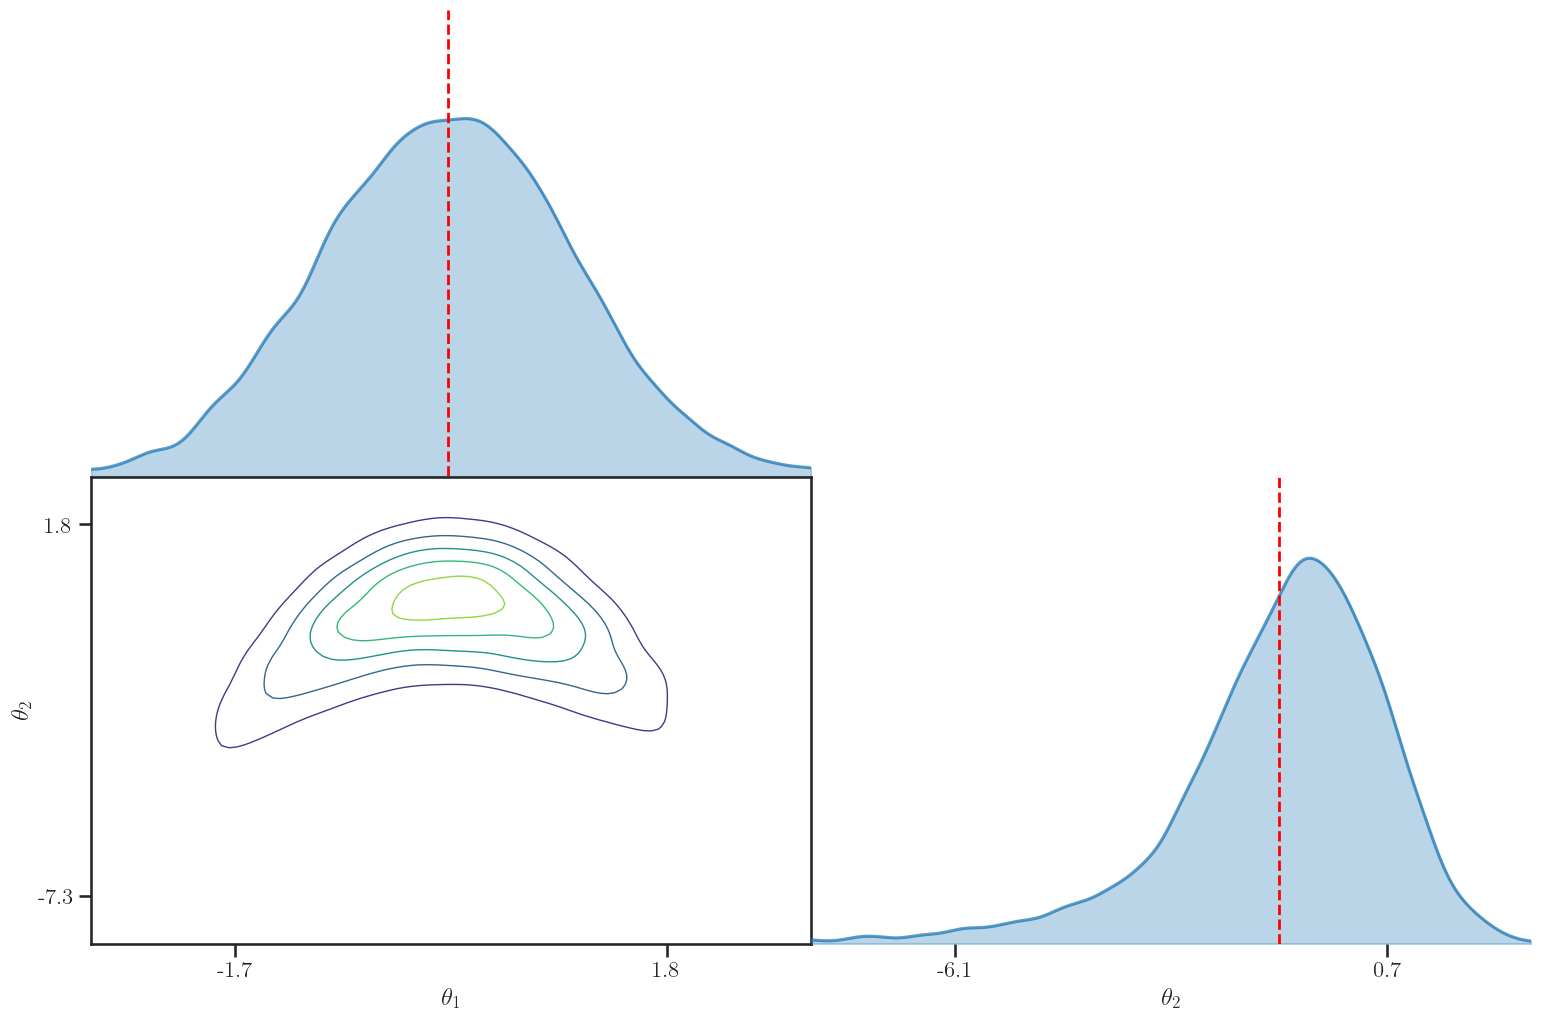

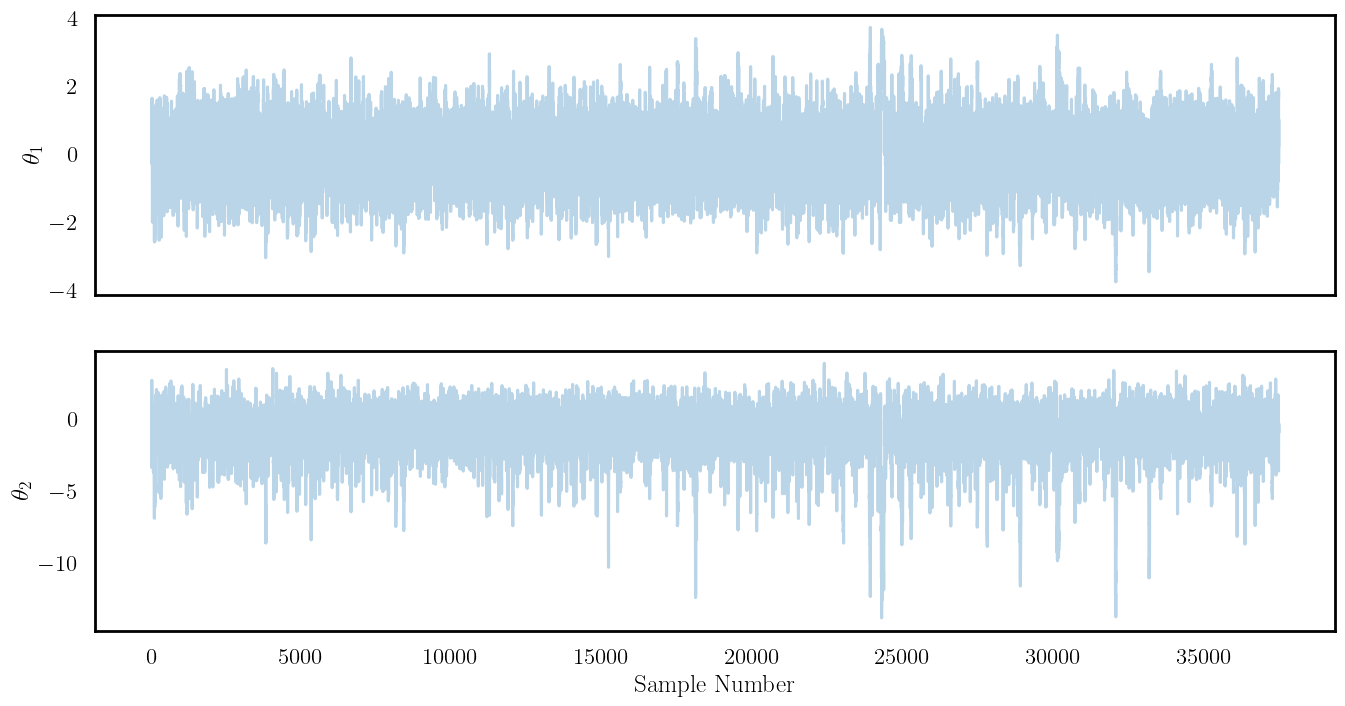

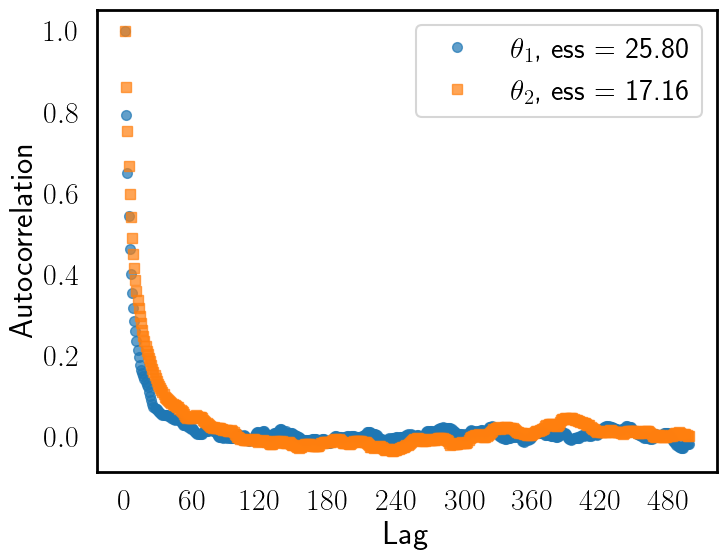

In [6]:
# Lets mix and match some kernels and proposals and run MCMC

# This is just a simple example of how to use the samosa package
from samosa.kernels.delayedrejection import DelayedRejectionKernel
from samosa.kernels.metropolis import MetropolisHastingsKernel
from samosa.proposals.gaussianproposal import GaussianRandomWalk
from samosa.proposals.adapters import HaarioAdapter
from samosa.core.proposal import AdaptiveProposal

from samosa.samplers.single_chain import MCMCsampler

from samosa.utils.post_processing import get_position_from_states, load_samples

# Define the proposal
proposal = GaussianRandomWalk(mu=np.zeros((2,1)), sigma=np.eye(2))
# proposal = IndependentProposal(mu=np.zeros((2,1)), sigma=2.38**2/2*np.eye(2))
adapter = HaarioAdapter(scale=2.38**2/2)
# adapter = GlobalAdapter(ar=0.234, adapt_start=1000, adapt_end=10000)
adaptive_proposal = AdaptiveProposal(proposal, adapter)

model = banana_model

# Define the kernel
# kernel = MetropolisHastingsKernel(model)
kernel = DelayedRejectionKernel(model, cov_scale=0.5)

output = 'banana-metropolis'

sampler = MCMCsampler(kernel, adaptive_proposal, initial_position=np.zeros((2, 1)), n_iterations=50000, print_iteration=1000, save_iteraton=100000) 
ar = sampler.run(output)

print("Acceptance rate:", ar)

# Load samples from the output directory
samples = load_samples(output)

# Get the positions of the samples
burnin = 0.25
positions = get_position_from_states(samples, burnin)
print("Positions shape:", positions.shape)

print("Mean of the samples:", np.mean(positions, axis=1))
print("Standard deviation of the samples:", np.std(positions, axis=1))

# Plot the scatter plot of the samples
from samosa.utils.post_processing import scatter_matrix, plot_trace, plot_lag
fig, _, _ = scatter_matrix([positions])
plt.show()

# Plot the trace of the samples
fig, _ = plot_trace(positions)
plt.show()

# Plot the lag of the samples
fig, _ = plot_lag(positions)
plt.show()